<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/My Drive/Chatbot_shared/reviews_Video_Games_5.json.gz')



In [4]:
#Removes everything in except the review and overall score. Then removes
# all reviews with an score of 3 beacuse of them being natrual when we set all
#score under 3 to 0(negative) and score over 3 to 1(positive)

df=df.get(['reviewText','overall'])
df=df[df.overall != 3.0] 
df=df.replace(1.0, 0)
df=df.replace(2.0, 0)
df=df.replace(4.0, 1)
df=df.replace(5.0, 1)
reviews = df.reviewText
labels = df.overall
df


,reviewText,overall
0,Installing the game was a struggle (because of...,0.0
1,If you like rally cars get this game you will ...,1.0
2,1st shipment received a book instead of the ga...,0.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,1.0
5,"Overall this is a well done racing game, with ...",1.0
...,...,...
231775,Funny people on here are rating sellers that a...,1.0
231776,All this is is the Deluxe 32GB Wii U with Mari...,0.0
231777,The package should have more red on it and sho...,0.0
231778,Can get this at Newegg for $329.00 and the pac...,0.0


In [0]:
#Removes symbols and lowercases all characters
reviews = reviews.str.lower()
reviews = reviews.str.replace(r'[^\w\s]+','')

In [6]:
#Tokenizer
all_text = ' '.join(reviews)          # Makes on string of all texts.
words = all_text.split()

#Count all the words
count_words = Counter(words)          # Creats a counter function

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)
sorted_words

[('the', 2207986),
 ('and', 1148395),
 ('to', 1070778),
 ('a', 1023248),
 ('of', 815022),
 ('is', 739859),
 ('you', 719567),
 ('i', 711698),
 ('game', 647030),
 ('it', 622707),
 ('this', 527217),
 ('in', 487963),
 ('that', 436955),
 ('for', 395305),
 ('are', 330321),
 ('with', 312144),
 ('but', 307965),
 ('on', 278908),
 ('have', 278001),
 ('as', 264403),
 ('not', 213547),
 ('its', 198503),
 ('was', 197680),
 ('can', 196590),
 ('be', 193208),
 ('your', 187043),
 ('like', 185932),
 ('if', 175798),
 ('games', 172781),
 ('all', 169204),
 ('or', 169094),
 ('so', 168962),
 ('one', 161936),
 ('my', 160045),
 ('just', 149790),
 ('get', 142303),
 ('more', 141091),
 ('at', 137089),
 ('there', 134196),
 ('from', 132939),
 ('they', 132859),
 ('play', 132827),
 ('will', 129378),
 ('out', 120430),
 ('up', 117387),
 ('some', 116548),
 ('has', 113866),
 ('an', 113653),
 ('very', 110153),
 ('great', 106313),
 ('really', 104958),
 ('good', 104096),
 ('when', 101733),
 ('time', 100093),
 ('fun', 98337),

In [7]:
# Creats a vocabulary where each number corresponds to a word.

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

# Changes all word in reviews to interger values accoriding to vocab_to_int
reviews_int = []
for review in reviews:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])


[[3041, 1, 9, 23, 4, 3845, 76, 5, 29, 14, 1067, 451, 67590, 5151, 1043, 2, 478, 24, 58, 25, 1433, 70, 418, 73, 20, 48, 3116, 3, 1, 9, 8, 1213, 766, 695, 1258, 53, 1, 9, 23, 74, 8, 69, 27, 1, 549, 13, 8, 19, 3, 217, 1674, 3, 217, 13201, 1118, 64, 1097, 12, 1, 1365, 31, 77, 647, 3, 2692, 9862, 6142, 10, 12, 1, 2182, 2, 24004, 146, 3, 114, 189, 7984, 9, 103, 51, 1244, 5, 640, 390, 161117, 29, 161118, 973, 3, 36, 34, 1089, 40, 11595, 9574, 4449, 2, 7, 162, 3, 161119, 7, 14, 866, 34, 291, 28, 7, 412, 10, 25, 235, 3, 930, 10, 20, 1640], [28, 7, 27, 4449, 478, 36, 11, 9, 7, 43, 19, 14669, 6, 37, 3986, 3, 161120, 59121, 151, 194, 12, 2696, 39, 208, 4, 318, 4449, 226, 559, 211, 10, 6, 49, 4871, 2, 65, 1, 1452, 40, 1, 9, 49, 161121, 80805, 229, 208, 1, 90, 17, 10, 289, 35, 652], [1392, 10924, 1309, 4, 981, 301, 5, 1, 104091, 10924, 129, 4, 3725, 33, 9, 1969, 16, 4, 480, 915, 1070, 18, 6176, 604, 8, 129, 12, 3164, 16, 7984, 2, 1496, 73, 1978, 5, 1, 1457, 2, 1, 561, 41, 288, 257, 41, 24, 60, 22, 4

In [8]:
encoded_labels = np.array(labels)
encoded_labels

array([0., 1., 0., ..., 0., 0., 0.])

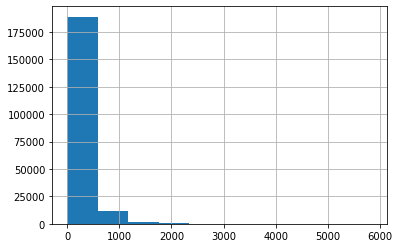

count    203505.000000
mean        197.909757
std         271.210808
min           0.000000
25%          43.000000
50%         102.000000
75%         239.000000
max        5842.000000
dtype: float64

In [9]:
#Prints a visualisation of how many word there are in each review
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
# Removes all reviews which have zero words in them.

reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [0]:
# Fucntion which zero padds and shortens all reviews to seq_length

def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review        
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features


In [12]:
features = np.array(pad_features(reviews_int,200))
features[10][:20]

array([    8,    19,    85,    79,   514,   486,    29,   151,   110,
         768,   649,    18,   307,     8,  1450,    19,     4,  1835,
       11662,   742])

In [13]:
# SPlitting data into training, validation and testing
split_frac = 0.6
len_feat=len(features)
encoded_labels = np.array(encoded_labels)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


type(train_y)

numpy.ndarray

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
# batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
# batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,    4,   52,    9],
        [   0,    0,    0,  ...,   58,  238, 3053],
        [   0,    0,    0,  ...,    1, 1048,   29],
        ...,
        [   0,    0,    0,  ...,   12,   26, 3330],
        [   0,    0,    0,  ...,    2,    1,  267],
        [   0,    0,    0,  ...,    5,  342, 4104]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)


In [16]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
# The file can be found in Canvas and must be placed in the same directory as the notebook)
fastText_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Chatbot_shared/wiki.simple.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [46]:
word='sweden'
#print(words[0])
test1=fastText_embeddings['sweden']
test2=fastText_embeddings['norway']

print(len(test1))
from scipy import spatial

result = 1 - spatial.distance.cosine(test1, test2)

print(result)

fastText_embeddings.most_similar(positive=['sweden'])

print(fastText_embeddings.wv.vectors.shape)

weights = torch.FloatTensor(fastText_embeddings.vectors)

print(weights)

300
0.597154974937439
(111051, 300)
tensor([[ 0.2892, -0.4608,  0.3514,  ...,  0.1331, -0.2347,  0.0053],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        [ 0.2013,  0.0104,  0.1623,  ..., -0.0931, -0.1408, -0.1326],
        ...,
        [ 0.2377, -0.0403, -0.0326,  ..., -0.0606,  0.0348, -0.2974],
        [ 0.5376, -0.2263,  0.0231,  ...,  0.0800, -0.3782, -0.2765],
        [ 0.1598,  0.0028, -0.2026,  ..., -0.0032, -0.1265, -0.1526]])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [18]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [0]:


class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [0]:
vocab_size = len(sorted_words) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
epochs = 1
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

print('hej0')

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    print('hej1')

    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        print(counter)

        if counter%print_every == 0:
            al_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in valid_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                print('val')
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

hej0
hej1
1
2
3
4
5
6


KeyboardInterrupt: ignored